# Import libraries

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from scipy import ndimage as ndi
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from feature_extraction_utils import postprocess_mask


def calc_nc_ratio(img_gray,nucleus_threshold=0.4,cytoplasm_threshold=0.6):
    nucleus_mask=img_gray<=nucleus_threshold
    nucleus_mask=postprocess_mask(nucleus_mask)

    cytoplasm_mask=img_gray<=cytoplasm_threshold
    cytoplasm_mask=postprocess_mask(cytoplasm_mask)
    cytoplasm_mask=np.logical_and(cytoplasm_mask,~nucleus_mask)

    nucleus_area=np.sum(nucleus_mask)
    cytoplasm_area=np.sum(cytoplasm_mask)
    return nucleus_area/(nucleus_area+cytoplasm_area)


# Load Data

In [2]:
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]
no_nucleus=(labels==2).sum(axis=(1,2))==0
images=images[~no_nucleus]
labels=labels[~no_nucleus]

X_train,X_test,Y_train,Y_test=train_test_split(images,labels,test_size=0.2,stratify=labels.mean((1,2))>=np.median(labels.mean((1,2))),random_state=42)
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.2,stratify=Y_train.mean((1,2))>=np.median(Y_train.mean((1,2))),random_state=42)

# Feature Extraction

In [3]:
from feature_extraction_utils import extract_and_organize_features
# Transform images into higher dimensional feature space by calculating multiple pixelwise features
# Extract RGB, Gabor, and Sobel features for train/val/test sets (GLCM and multiscale features disabled)

use_glcm = False
use_multiscale = False

X_train_features, X_train_features_dict = extract_and_organize_features(
    X_train,
    use_glcm=use_glcm,
    use_multiscale=use_multiscale
)

X_val_features, X_val_features_dict = extract_and_organize_features(
    X_val,
    use_glcm=use_glcm,
    use_multiscale=use_multiscale
)

X_test_features, X_test_features_dict = extract_and_organize_features(
    X_test,
    use_glcm=use_glcm,
    use_multiscale=use_multiscale
)


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

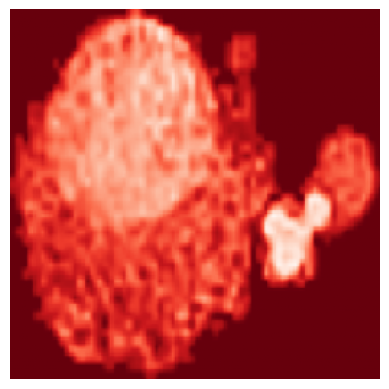

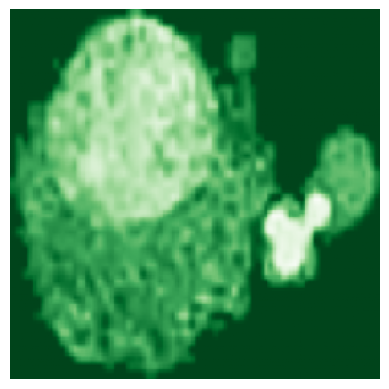

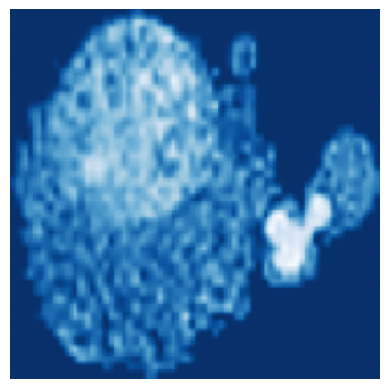

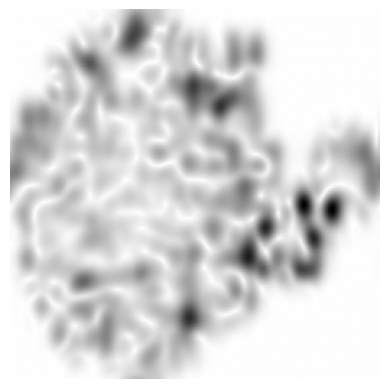

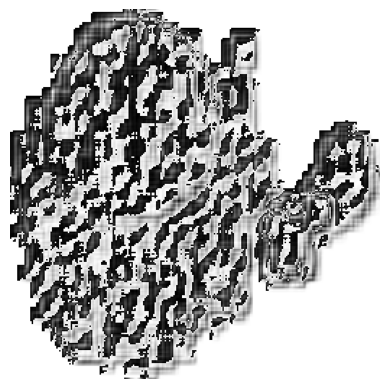

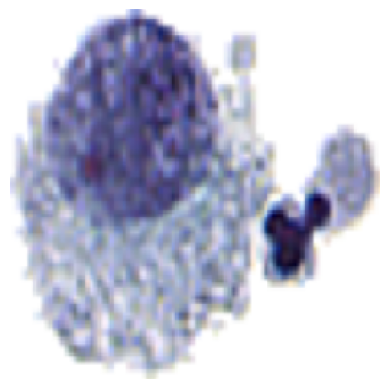

In [4]:
i=13
plt.figure()
plt.imshow(X_train_features_dict["RGB"][i][...,0],cmap="Reds")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features_dict["RGB"][i][...,1],cmap="Greens")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features_dict["RGB"][i][...,2],cmap="Blues")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features_dict["gabor"][i][...,0],cmap="gray_r")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features_dict["sobel"][i][...,0],cmap="gray_r")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features_dict["RGB"][i]/255)
plt.axis("off")

# KMeans

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

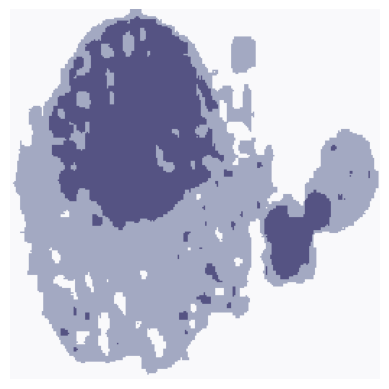

In [ ]:
# Perform K-means clustering on RGB image to segment it into 3 distinct color regions
# 1. Reshape image into array of RGB pixels and convert to float32
# 2. Apply K-means to find 3 cluster centers and assign each pixel to nearest center
img_=X_train_features_dict["RGB"][i][...,:3]
Z = img_.reshape((-1,3))
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img_.shape))
plt.imshow(res2)
plt.axis("off")

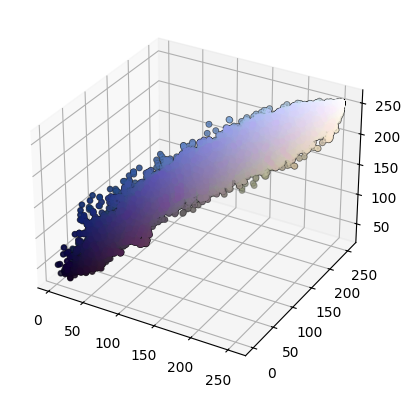

In [6]:
# Create a 3D scatter plot showing the distribution of RGB pixel values
# Each point represents a pixel, with its position determined by its RGB values (R,G,B coordinates)
# Points are plotted with both black outlines and their true colors for better visibility
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c='black', s=15)  # Larger black points for outline
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c=Z/255, s=10)  # Smaller colored points on top

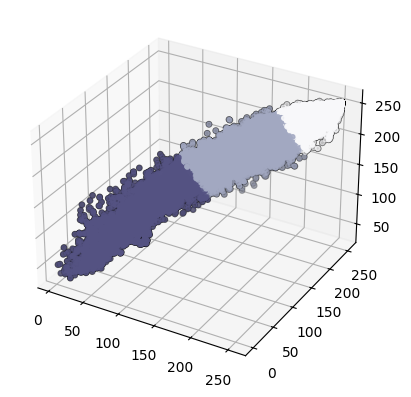

In [7]:
# Create a 3D scatter plot showing the RGB pixel values after K-means clustering
# Points are plotted twice - once in black (larger) for outline visibility
# and once colored according to their assigned cluster centers (smaller points)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c='black', s=15)  # Larger black points for outline
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c=res/255, s=10)  # Smaller colored points on top

In [8]:
from feature_extraction_utils import fit_kmeans_across_all_images,assign_intensities,calculate_nc_ratio

# 1. Apply K-means clustering to segment RGB images into distinct regions
n_clusters = 4
Y_train_kmeans = fit_kmeans_across_all_images(X_train_features_dict["RGB"], n_clusters)
Y_val_kmeans = fit_kmeans_across_all_images(X_val_features_dict["RGB"], n_clusters)
Y_test_kmeans = fit_kmeans_across_all_images(X_test_features_dict["RGB"], n_clusters)

# 2. Calculate true nucleus-to-cytoplasm (NC) ratios for validation and test sets
y_val_nc_ratio_true = (Y_val == 2).sum((1,2)) / (Y_val > 0).sum((1,2))
y_test_nc_ratio_true = (Y_test == 2).sum((1,2)) / (Y_test > 0).sum((1,2))

# 3. Predict NC ratios for validation and test sets using K-means clustering results
y_val_nc_ratio_pred = []
for y_val_kmeans, x_val_gray in zip(Y_val_kmeans, X_val_features_dict['gray']):
    nucleus_mask, cytoplasm_mask = assign_intensities(y_val_kmeans, x_val_gray, n_clusters)
    nc_ratio = calculate_nc_ratio(nucleus_mask, cytoplasm_mask)
    y_val_nc_ratio_pred.append(nc_ratio)

y_test_nc_ratio_pred = []
for y_test_kmeans, x_test_gray in zip(Y_test_kmeans, X_test_features_dict['gray']):
    nucleus_mask, cytoplasm_mask = assign_intensities(y_test_kmeans, x_test_gray, n_clusters)
    nc_ratio = calculate_nc_ratio(nucleus_mask, cytoplasm_mask)
    y_test_nc_ratio_pred.append(nc_ratio)


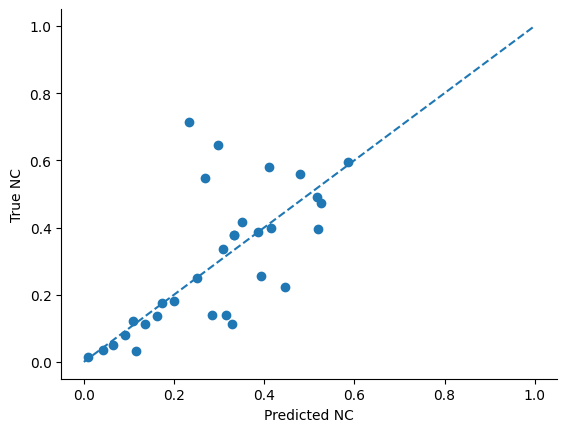

In [9]:
plt.scatter(y_val_nc_ratio_pred,y_val_nc_ratio_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

In [10]:
# Calculate Spearman correlation between predicted and true nucleus-to-cytoplasm ratios
spearmanr(y_val_nc_ratio_pred,y_val_nc_ratio_true,nan_policy="omit")

SignificanceResult(statistic=np.float64(0.7201612903225807), pvalue=np.float64(4.934966300002815e-06))

In [11]:
# Calculate mean absolute error between predicted and true NC ratios
np.abs(y_val_nc_ratio_pred-y_val_nc_ratio_true).mean()

np.float64(0.09265860769009936)

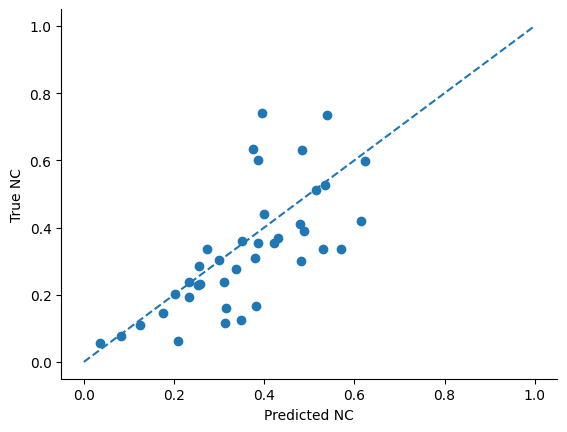

In [ ]:
# Plot scatter plot comparing predicted vs true nucleus-to-cytoplasm ratios on test set
plt.scatter(y_test_nc_ratio_pred,y_test_nc_ratio_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

In [13]:
spearmanr(y_test_nc_ratio_pred,y_test_nc_ratio_true,nan_policy="omit")

SignificanceResult(statistic=np.float64(0.7809716599190284), pvalue=np.float64(4.4855422160698504e-09))

In [14]:
np.abs(y_test_nc_ratio_pred-y_test_nc_ratio_true).mean()

np.float64(0.09747915554778071)

# Random Forest

In [15]:
# Combine RGB, Sobel, and Gabor features for train, validation, and test sets
# Subsample the training and validation data to reduce computational load
# Train a Random Forest classifier and make predictions on validation and test sets

# Combine features
X_train_features_combined=np.concatenate([X_train_features_dict["RGB"],X_train_features_dict["sobel"],X_train_features_dict["gabor"]],axis=-1).reshape(-1,X_train_features_dict["RGB"].shape[-1]+X_train_features_dict["sobel"].shape[-1]+X_train_features_dict["gabor"].shape[-1])
X_val_features_combined=np.concatenate([X_val_features_dict["RGB"],X_val_features_dict["sobel"],X_val_features_dict["gabor"]],axis=-1).reshape(-1,X_val_features_dict["RGB"].shape[-1]+X_val_features_dict["sobel"].shape[-1]+X_val_features_dict["gabor"].shape[-1])
X_test_features_combined=np.concatenate([X_test_features_dict["RGB"],X_test_features_dict["sobel"],X_test_features_dict["gabor"]],axis=-1).reshape(-1,X_test_features_dict["RGB"].shape[-1]+X_test_features_dict["sobel"].shape[-1]+X_test_features_dict["gabor"].shape[-1])

# Subsample training and validation data
idx=np.arange(X_train_features_combined.shape[0])
idx=np.random.choice(idx,size=25000,replace=False)
X_train_features_combined_subsampled=X_train_features_combined[idx] 
Y_train_subsampled=Y_train.reshape(-1)[idx]

idx=np.arange(X_val_features_combined.shape[0])
idx=np.random.choice(idx,size=10000,replace=False)
X_val_features_combined_subsampled=X_val_features_combined[idx] 
Y_val_subsampled=Y_val.reshape(-1)[idx]

# Train Random Forest and make predictions
rf=RandomForestClassifier(n_estimators=250,random_state=42,class_weight="balanced")
rf.fit(X_train_features_combined_subsampled,Y_train_subsampled)

Y_val_pred=rf.predict(X_val_features_combined).reshape(Y_val.shape)
Y_test_pred=rf.predict(X_test_features_combined).reshape(Y_test.shape)


Text(0, 0.5, 'True NC')

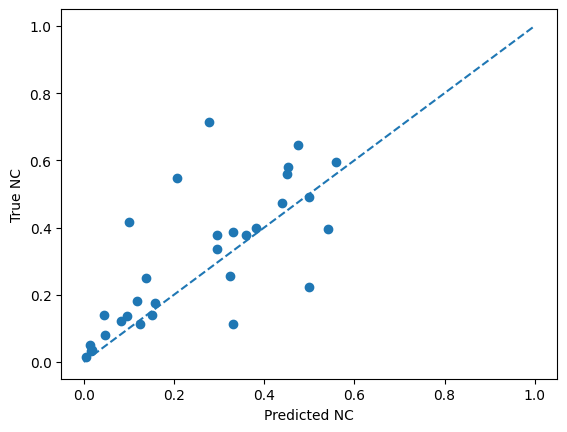

In [16]:
y_val_nc_ratio_pred=(Y_val_pred==2).sum((1,2))/(Y_val_pred>0).sum((1,2))

plt.scatter(y_val_nc_ratio_pred,y_val_nc_ratio_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")

Text(0, 0.5, 'True NC')

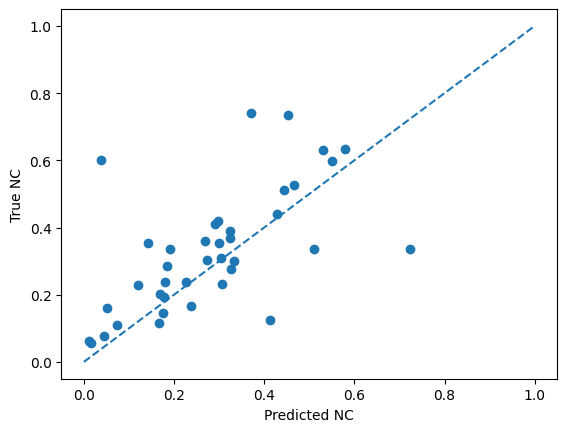

In [17]:
y_test_nc_ratio_pred=(Y_test_pred==2).sum((1,2))/(Y_test_pred>0).sum((1,2))

plt.scatter(y_test_nc_ratio_pred,y_test_nc_ratio_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")

In [18]:
spearmanr(y_test_nc_ratio_pred,y_test_nc_ratio_true,nan_policy="omit")


SignificanceResult(statistic=np.float64(0.6674089068825911), pvalue=np.float64(3.4729019661917314e-06))

In [19]:
np.abs(y_test_nc_ratio_pred-y_test_nc_ratio_true).mean()

np.float64(0.10767806079967056)

In [20]:
# Hyperparameter tuning for Random Forest using RandomizedSearchCV
# 1. Define parameter grid for search
# 2. Set up cross-validation strategy using PredefinedSplit
# 3. Perform randomized search to find optimal hyperparameters

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [50, 100, 200],
    'min_samples_leaf': [20, 50, 100],
    'max_features': ['sqrt', 'log2', None]
}

ps = PredefinedSplit(test_fold=np.hstack((-np.ones(len(X_train_features_combined_subsampled)),np.zeros(len(X_val_features_combined_subsampled)))))

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=35,  # Number of random combinations to try
    cv=ps,  # Number of cross-validation folds
    scoring='f1_macro',  # Scoring metric
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Perform the randomized search
random_search.fit(np.concatenate([X_train_features_combined_subsampled,X_val_features_combined_subsampled]), np.concatenate([Y_train_subsampled.flatten(),Y_val_subsampled.flatten()]))


Fitting 1 folds for each of 35 candidates, totalling 35 fits
[CV] END max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=50, n_estimators=50; total time=   0.8s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=100, min_samples_split=200, n_estimators=50; total time=   0.8s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=20, min_samples_split=50, n_estimators=50; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=50, n_estimators=50; total time=   1.1s
[CV] END max_depth=3, max_features=log2, min_samples_leaf=50, min_samples_split=200, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   1.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=100, min_samples_split=200, n_estimators=50; total time=   1.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=200, n_e

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0], shape=(35000,))),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_estimators=250,
                                                    random_state=42),
                   n_iter=35, n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 5, 7],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [20, 50, 100],
                                        'min_samples_split': [50, 100, 200],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='f1_macro', verbose=2)

Text(0, 0.5, 'True NC')

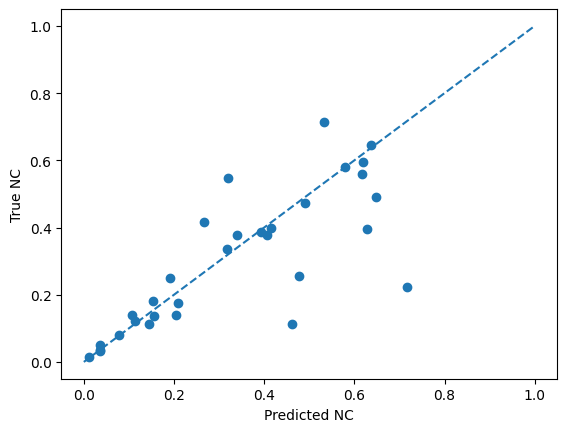

In [21]:
# Make predictions on validation and test sets using optimized random forest model
# Calculate predicted nuclear-to-cytoplasm (NC) ratio by counting nuclear pixels (class 2) divided by total non-background pixels
# Plot predicted vs true NC ratios with ideal 1:1 line to evaluate model performance
Y_val_pred=random_search.predict(X_val_features_combined).reshape(Y_val.shape)
Y_test_pred=random_search.predict(X_test_features_combined).reshape(Y_test.shape)

y_val_nc_ratio_pred=(Y_val_pred==2).sum((1,2))/(Y_val_pred>0).sum((1,2))

plt.scatter(y_val_nc_ratio_pred,y_val_nc_ratio_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")


Text(0, 0.5, 'True NC')

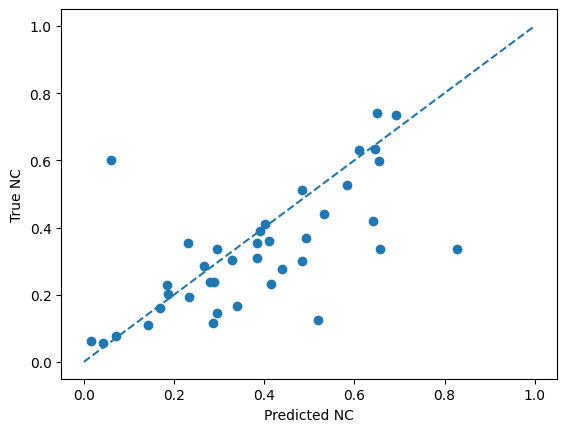

In [22]:
y_test_nc_ratio_pred=(Y_test_pred==2).sum((1,2))/(Y_test_pred>0).sum((1,2))

plt.scatter(y_test_nc_ratio_pred,y_test_nc_ratio_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")

In [23]:
spearmanr(y_test_nc_ratio_pred,y_test_nc_ratio_true,nan_policy="omit")


SignificanceResult(statistic=np.float64(0.6817813765182187), pvalue=np.float64(1.7635615839809523e-06))

In [24]:
np.abs(y_test_nc_ratio_pred-y_test_nc_ratio_true).mean()

np.float64(0.10775534917452134)

In [26]:
# Generate classification reports for validation and test sets
from sklearn.metrics import classification_report

# Define class names
class_names = ['background', 'cytoplasm', 'nucleus']

# Flatten predictions and true labels for validation set
y_val_true_flat = Y_val.flatten()
y_val_pred_flat = Y_val_pred.flatten()

print("Validation Set Classification Report:")
print(classification_report(y_val_true_flat, y_val_pred_flat, target_names=class_names))

# Flatten predictions and true labels for test set  
y_test_true_flat = Y_test.flatten()
y_test_pred_flat = Y_test_pred.flatten()

print("\nTest Set Classification Report:")
print(classification_report(y_test_true_flat, y_test_pred_flat, target_names=class_names))


Validation Set Classification Report:
              precision    recall  f1-score   support

  background       0.98      0.96      0.97    735746
   cytoplasm       0.91      0.87      0.89    888107
     nucleus       0.77      0.87      0.82    407763

    accuracy                           0.91   2031616
   macro avg       0.89      0.90      0.89   2031616
weighted avg       0.91      0.91      0.91   2031616


Test Set Classification Report:
              precision    recall  f1-score   support

  background       0.98      0.98      0.98    906849
   cytoplasm       0.90      0.82      0.86   1087940
     nucleus       0.73      0.85      0.79    561115

    accuracy                           0.88   2555904
   macro avg       0.87      0.88      0.87   2555904
weighted avg       0.89      0.88      0.89   2555904

